
#Auto MPG
Donated on 7/6/1993
Revised from CMU StatLib library, data concerns city-cycle fuel consumption

#Dataset Characteristics
Multivariate

#Subject Area
Other

#Associated Tasks
Regression

#Feature Type
Real, Categorical, Integer

# Instances
398
# Features
7

# Dataset Information

# Additional Information

This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute.  The original dataset is available in the file "auto-mpg.data-original".

## Problem Statement
---


"*The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.*" (Quinlan, 1993)


---



# Has Missing Values?

Yes



# Dataset Characteristics



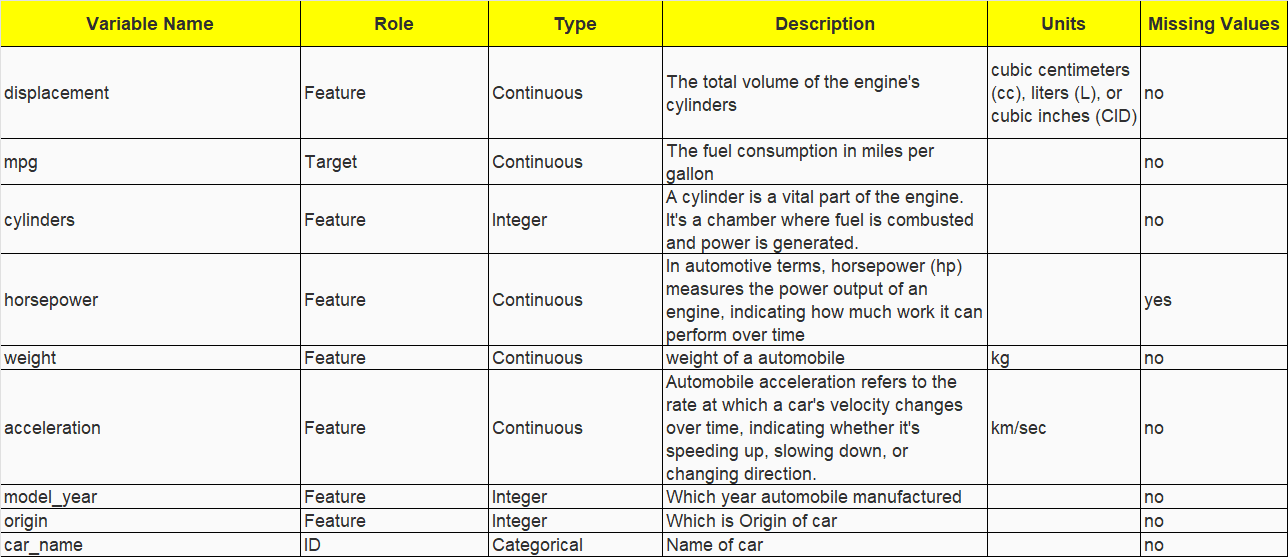

5. Number of Instances: 398

6. Number of Attributes: 9 including the class attribute

7. Attribute Information:

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

8. Missing Attribute Values:  horsepower has 6 missing values

# Download Dataset

In [122]:
#@title Download Dataset
!wget -qq https://archive.ics.uci.edu/static/public/9/auto+mpg.zip
!ls | grep ".zip"
print("Dataset downloaded successfully!")

auto+mpg.zip
auto+mpg.zip.1
auto+mpg.zip.2
auto+mpg.zip.3
auto+mpg.zip.4
Dataset downloaded successfully!


##Unzip the data

In [123]:
import zipfile
with zipfile.ZipFile('/content/auto+mpg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Import Required Packages

In [124]:
# Loading the Required Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [125]:
# ========== NEW IMPORTS FOR PIPELINE BUILDING ========

# to create pipeline
from sklearn.pipeline import Pipeline

# for including custom preprocessors within pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# 1. Pre-Pipeline-Steps:

# 1.1 Load, Explore, and Prepare the Data Set
Load the dataset
Understand different features in the training dataset
Understand the data types of each columns
Notice the columns of missing values

In [126]:
autompg = pd.read_csv('auto-mpg.data', delim_whitespace=True, header=None)
autompg.shape

<ipython-input-126-ca118ee3351d>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  autompg = pd.read_csv('auto-mpg.data', delim_whitespace=True, header=None)


(398, 9)

In [127]:
autompg.columns = ['mpg', 'cylinders', 'displacement', 'horsepower','weight','acceleration','model_year','origin','car_name']

In [128]:
autompg.head()
autompg.to_csv('autompg.csv', index=False)

In [201]:
unused_colms = ['origin', 'car_name']   # unused columns will be removed at later stage
target_col = ['mpg']

numerical_features = []
categorical_features = []

for col in autompg.columns:
    if col not in target_col + unused_colms:
        if autompg[col].dtypes == 'float64' or autompg[col].dtypes == 'int':
            numerical_features.append(col)
        else:
            categorical_features.append(col)


print('Number of numerical variables: {}'.format(len(numerical_features)),":" , numerical_features)

print('Number of categorical variables: {}'.format(len(categorical_features)),":" , categorical_features)

Number of numerical variables: 6 : ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
Number of categorical variables: 0 : []


In [130]:
unique_cylinders = autompg['origin'].unique()

# Print the unique values
print(unique_cylinders)

# Check for non-numerical values
non_numeric = pd.to_numeric(autompg['horsepower'], errors='coerce').isnull()

# Print the rows with non-numerical values
print(autompg[non_numeric])

[1 3 2]
      mpg  cylinders  displacement horsepower  weight  acceleration  \
32   25.0          4          98.0          ?  2046.0          19.0   
126  21.0          6         200.0          ?  2875.0          17.0   
330  40.9          4          85.0          ?  1835.0          17.3   
336  23.6          4         140.0          ?  2905.0          14.3   
354  34.5          4         100.0          ?  2320.0          15.8   
374  23.0          4         151.0          ?  3035.0          20.5   

     model_year  origin              car_name  
32           71       1            ford pinto  
126          74       1         ford maverick  
330          80       2  renault lecar deluxe  
336          80       1    ford mustang cobra  
354          81       2           renault 18i  
374          82       1        amc concord dl  


In [131]:
# Find and count missing values in each column
missing_values = autompg.isnull().sum()

# Print the result
print(missing_values)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


In [202]:
# Replace '?' with NaN
autompg['horsepower'] = autompg['horsepower'].replace('?', np.nan)

# Convert horsepower to numeric
autompg['horsepower'] = pd.to_numeric(autompg['horsepower'])

# Calculate the median horsepower (excluding NaN values)
median_horsepower = autompg['horsepower'].median()

# Replace NaN values with the median
autompg['horsepower'] = autompg['horsepower'].fillna(median_horsepower)


# Class for Specific operation

# Build a Class for handling outliers in numerical columns
Instead of removing the outliers, change their values
to upper-bound, if the value is higher than upper-bound, or
to lower-bound, if the value is lower than lower-bound respectively.

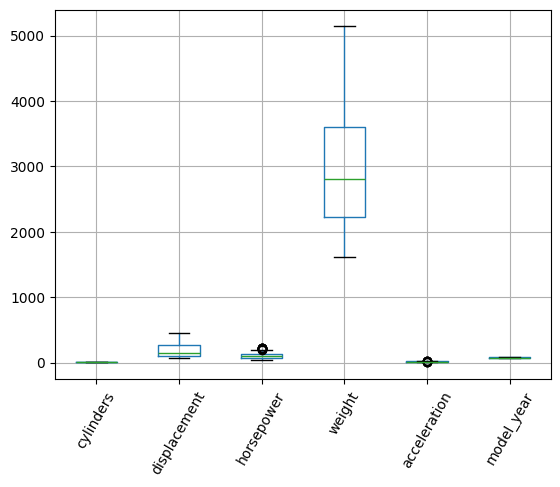

In [203]:
autompg[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [204]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """
    Change the outlier values:
        - to upper-bound, if the value is higher than upper-bound, or
        - to lower-bound, if the value is lower than lower-bound respectively.
    """

    def __init__(self, variable:str):
      if not isinstance(variable, str):
          raise ValueError("variables should be a string")
      self.variable = variable


    def fit(self, X: pd.DataFrame, y: pd.Series = None):
      X = X.copy()
      if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
        # we need the fit statement to accomodate the sklearn pipeline
      q1 = X.describe()[self.variable].loc['25%']
      q3 = X.describe()[self.variable].loc['75%']
      iqr = q3 - q1
      self.lower_bound = q1 - (1.5 * iqr)
      self.upper_bound = q3 + (1.5 * iqr)
      return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
      X = X.copy()
      if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
      #for col in X.columns:
      # q1 = X.describe()[col].loc['25%']
      # q3 = X.describe()[col].loc['75%']
      # iqr = q3 - q1
      # lower_bound = q1 - (1.5 * iqr)
      # upper_bound = q3 + (1.5 * iqr)
      for i in X.index:
        if X.loc[i,self.variable] > self.upper_bound:
          X.loc[i,self.variable]= self.upper_bound
        if X.loc[i,self.variable] < self.lower_bound:
          X.loc[i,self.variable]= self.lower_bound
      return X


In [205]:
for col in numerical_features:
  print(col)

cylinders
displacement
horsepower
weight
acceleration
model_year


In [206]:
# Handle outliers for all numerical columns
for col in numerical_features:
  outlier_handler = OutlierHandler(col)
  outlier_handler.fit(autompg)
  outlier_handled = outlier_handler.transform(autompg)

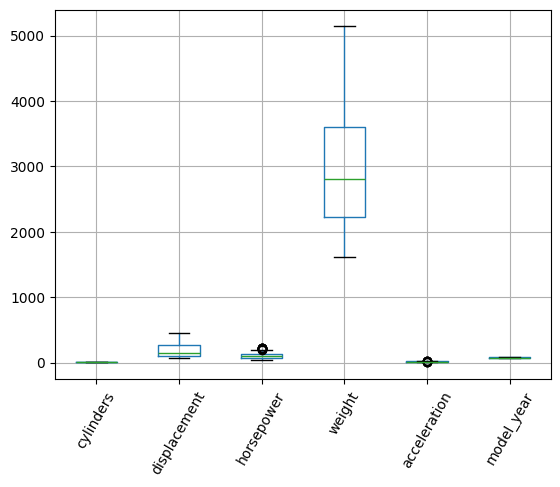

In [207]:
autompg[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [208]:
outlier_handled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [209]:
from sklearn.base import BaseEstimator, TransformerMixin

class AutoMPGPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transformer that wraps AutoMPGPipeline logic to be compatible with sklearn Pipeline.
    """

    def __init__(self, drop_columns=None, label_column='mpg'):
        self.drop_columns = drop_columns if drop_columns else ['origin', 'car_name']
        self.label_column = label_column
        self.quantile_transformer = QuantileTransformer(random_state=0)

    def fit(self, X, y=None):
        self.feature_columns_ = X.drop(self.drop_columns + [self.label_column], axis=1).columns
        X_trans = X[self.feature_columns_]
        self.quantile_transformer.fit(X_trans)
        return self

    def transform(self, X):
        X_trans = X[self.feature_columns_]
        X_trans = self.quantile_transformer.transform(X_trans)
        return X_trans


In [230]:
autompg_pipe = Pipeline([

    #

    # outlier
    ('outlier handler1', OutlierHandler('cylinders')),
    ('outlier handler2', OutlierHandler('displacement')),
    ('outlier handler3', OutlierHandler('horsepower')),
    ('outlier handler4', OutlierHandler('weight')),
    ('outlier handler5', OutlierHandler('acceleration')),
    ('outlier handler6', OutlierHandler('model_year')),
    ('autompg_preprocessor', AutoMPGPreprocessor(drop_columns=['origin','car_name'], label_column='mpg')),
    # scale
    ('scaler', StandardScaler()),

    # Model fit
    ('model_rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])

In [235]:
from sklearn.model_selection import train_test_split

X = autompg.copy()
y = autompg['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

autompg_pipe.fit(X_train, y_train)
y_pred = autompg_pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R² Score on Test Data: {r2:.4f}')


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(


R² Score on Test Data: 0.9083


# Fit Pipeline

1. Separate target and prediction features
2. Split data into train and test set
3. Fit pipeline on train set
4. Get prediction on test set
5. Calculate the mse and r2_score

In [219]:
x = autompg.drop(['origin','car_name'], axis=1)

y = autompg['mpg']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((318, 7), (80, 7))

In [221]:
y_train.head()

,mpg
3,16.0
18,27.0
376,37.0
248,36.1
177,23.0


In [222]:
autompg_pipe.fit(X_train,y_train)
y_pred = autompg_pipe.predict(X_test)



# Calculate the accuracy
print("Accuracy(in %):", r2_score(y_test, y_pred)*100)

Accuracy(in %): 99.98097361144515


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(


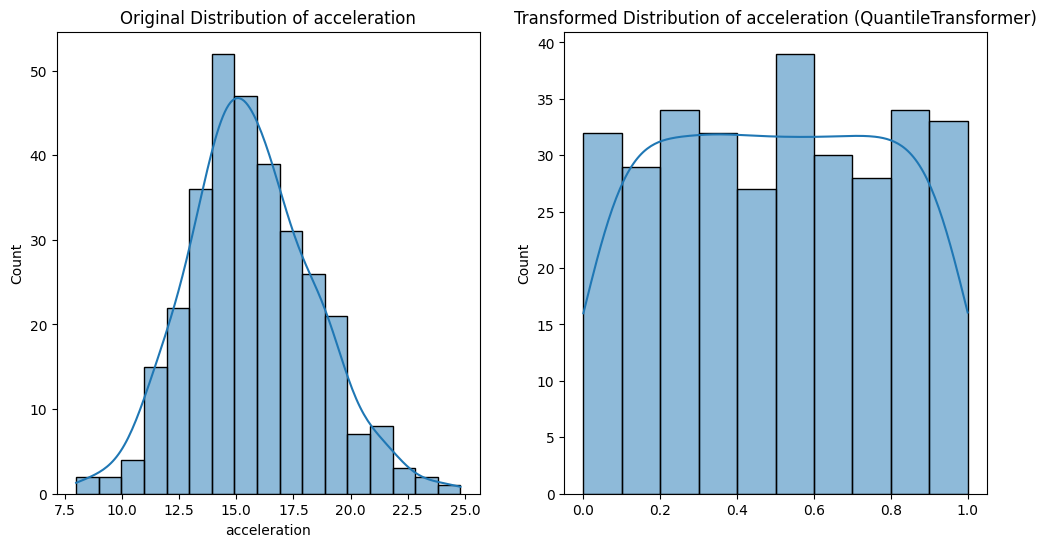

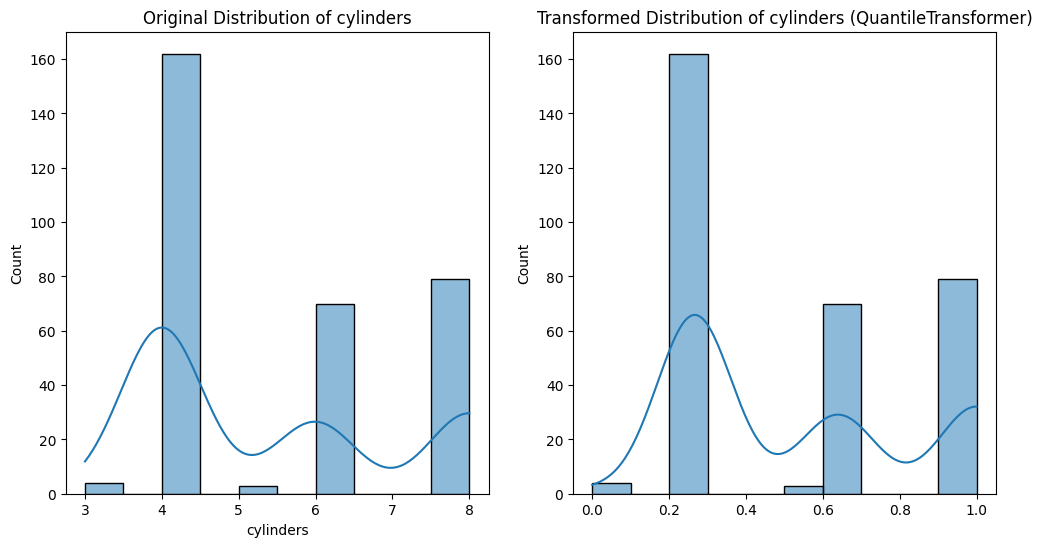

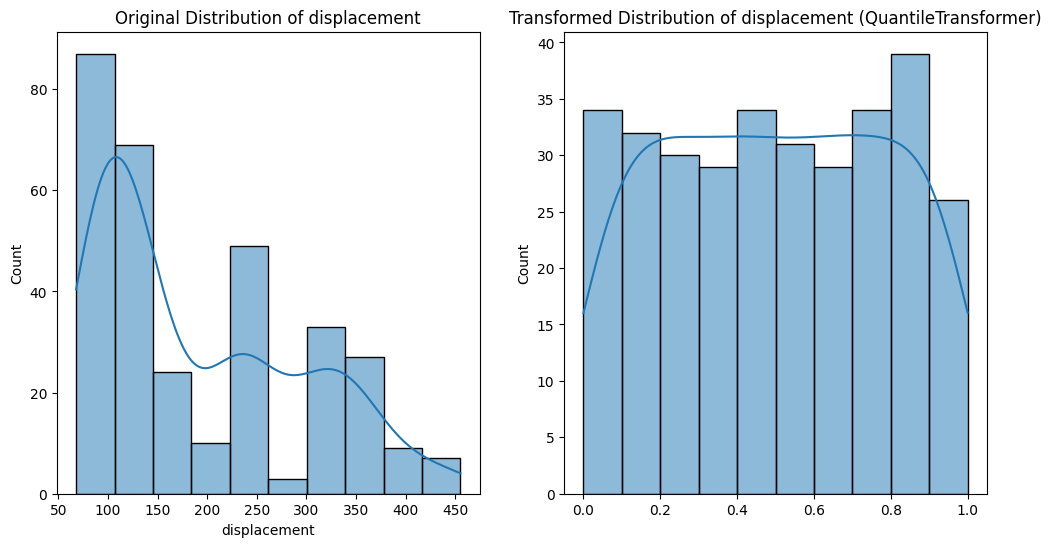

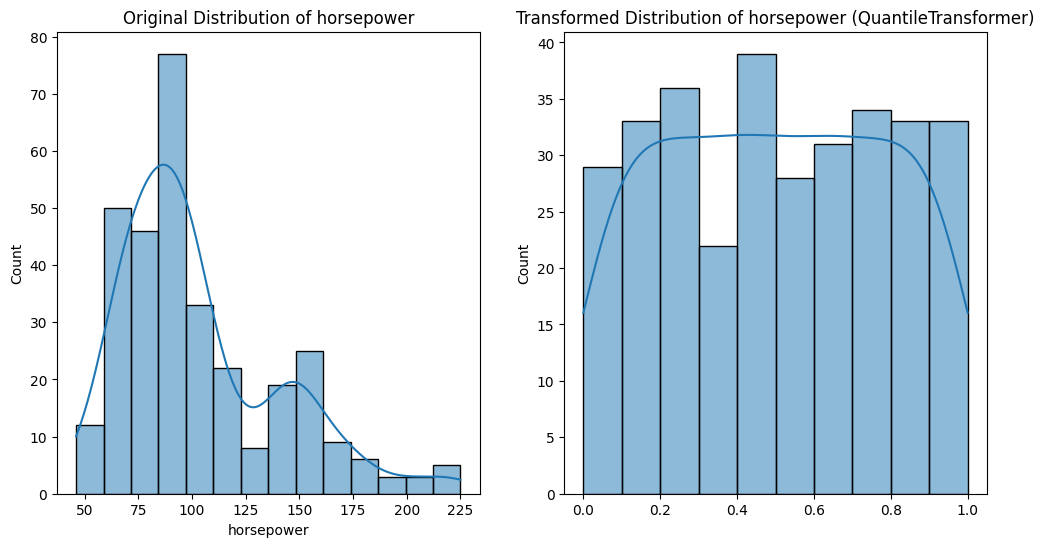

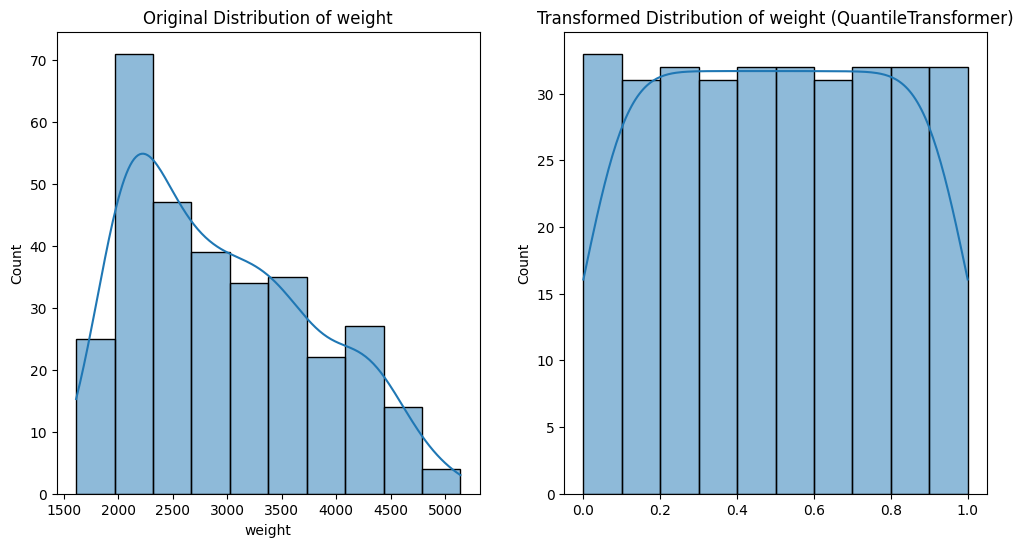

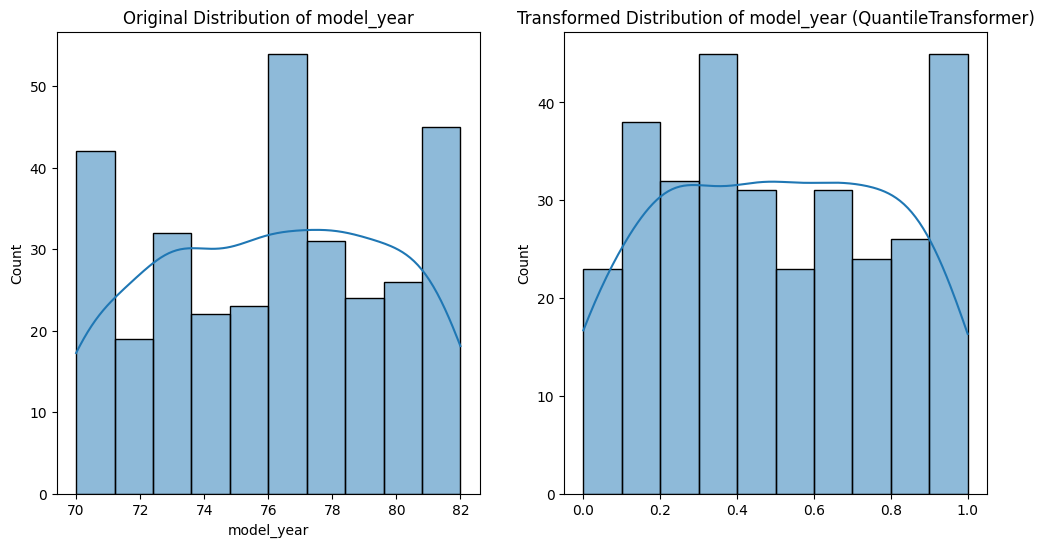

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import sklearn.preprocessing as preprocessing # Import the preprocessing module from sklearn

# Assuming 'autompg' is your DataFrame
x = autompg.drop(['origin', 'car_name'], axis=1)
y = autompg['mpg']

# Convert continuous labels to discrete classes
y = [int(label) for label in y]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)


# Choose a column to visualize (e.g., 'cylinders')
column_name = 'acceleration'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot


# Choose a column to visualize (e.g., 'cylinders')
column_name = 'cylinders'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot


# Choose a column to visualize (e.g., 'cylinders')
column_name = 'displacement'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot



# Choose a column to visualize (e.g., 'cylinders')
column_name = 'horsepower'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot



# Choose a column to visualize (e.g., 'cylinders')
column_name = 'weight'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot

#model_year


# Choose a column to visualize (e.g., 'cylinders')
column_name = 'model_year'
column_index = X_train.columns.get_loc(column_name)

# Create a figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original data distribution
sns.histplot(X_train.iloc[:, column_index], ax=axes[0], kde=True)  # Histogram with KDE
axes[0].set_title(f'Original Distribution of {column_name}')

# Plot the transformed data distribution
sns.histplot(X_train_trans[:, column_index], ax=axes[1], kde=True)  # Histogram with KDE
axes[1].set_title(f'Transformed Distribution of {column_name} (QuantileTransformer)')

plt.show()  # Show the plot



In [223]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.preprocessing as preprocessing # Import the preprocessing module from sklearn

pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)

# Convert continuous labels to discrete classes
y = [int(label) for label in y]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)
np.percentile(X_train.iloc[:, 0].values, [0, 25, 50, 75, 100])
np.percentile(X_train_trans[:, 0], [0, 25, 50, 75, 100])
np.percentile(X_test.iloc[:, 0].values, [0, 25, 50, 75, 100])
np.percentile(X_test_trans[:, 0], [0, 25, 50, 75, 100])
X_lognormal = np.random.RandomState(616).lognormal(size=(3, 3))
X_lognormal
pt.fit_transform(X_lognormal)

# L1 regularization
model_l1 = LogisticRegression(max_iter=100, solver='liblinear')  # Adjust C as needed
model_l1.fit(X_train, y_train)

# Make predictions
y_pred = model_l1.predict(X_test)

# Evaluate the model (using appropriate regression metrics like R-squared or Mean Squared Error)
from sklearn.metrics import r2_score
print("R-squared:", r2_score(y_test, y_pred))

R-squared: 0.8640923372649759


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(


# Check for package versions may be used for requirements.txt file

In [81]:
!pip -qq install pydantic
!pip -qq install strictyaml
!pip -qq install ruamel.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 20.4 MB/s eta 0:00:00


In [82]:
import numpy as np
import pandas as pd
import sklearn
import pydantic
import strictyaml
import ruamel.yaml
import joblib

In [83]:
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)
print(pydantic.__version__)
print(strictyaml.__version__)
print(ruamel.yaml.__version__)
print(joblib.__version__)

2.0.2
2.2.2
1.6.1
2.11.3
1.6.2
0.18.10
1.4.2
